Correlation Coefficient between FREQ and CIRAF ZONES: -0.02581962031965732
Correlation Coefficient between FREQ and CIRAF ZONES: -0.02581962031965732


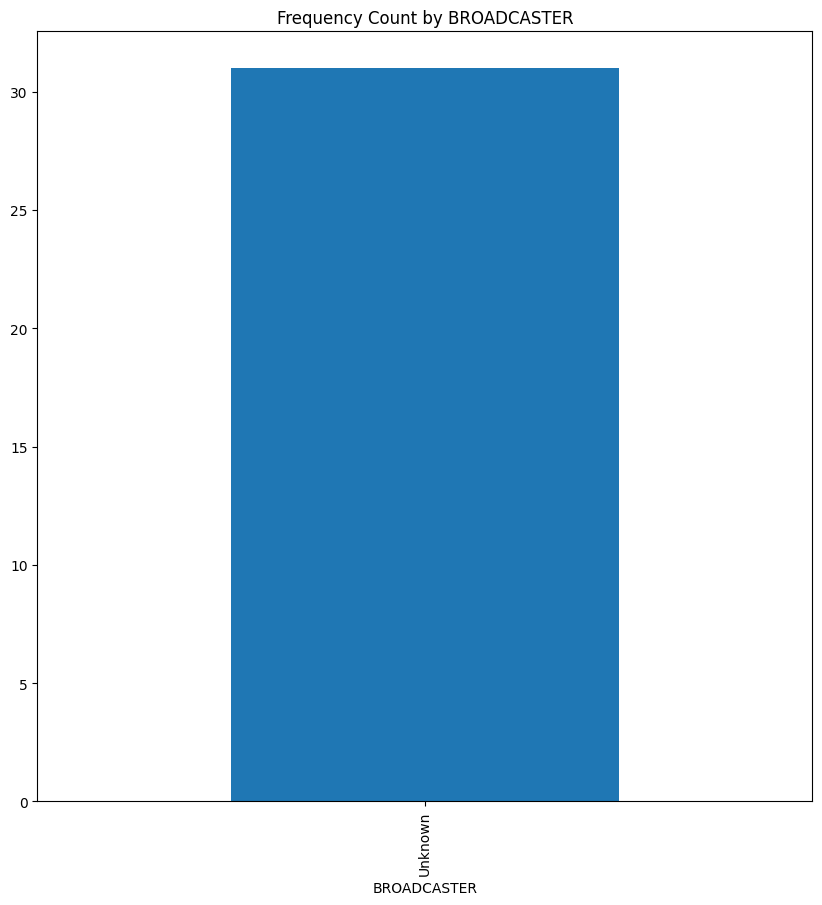

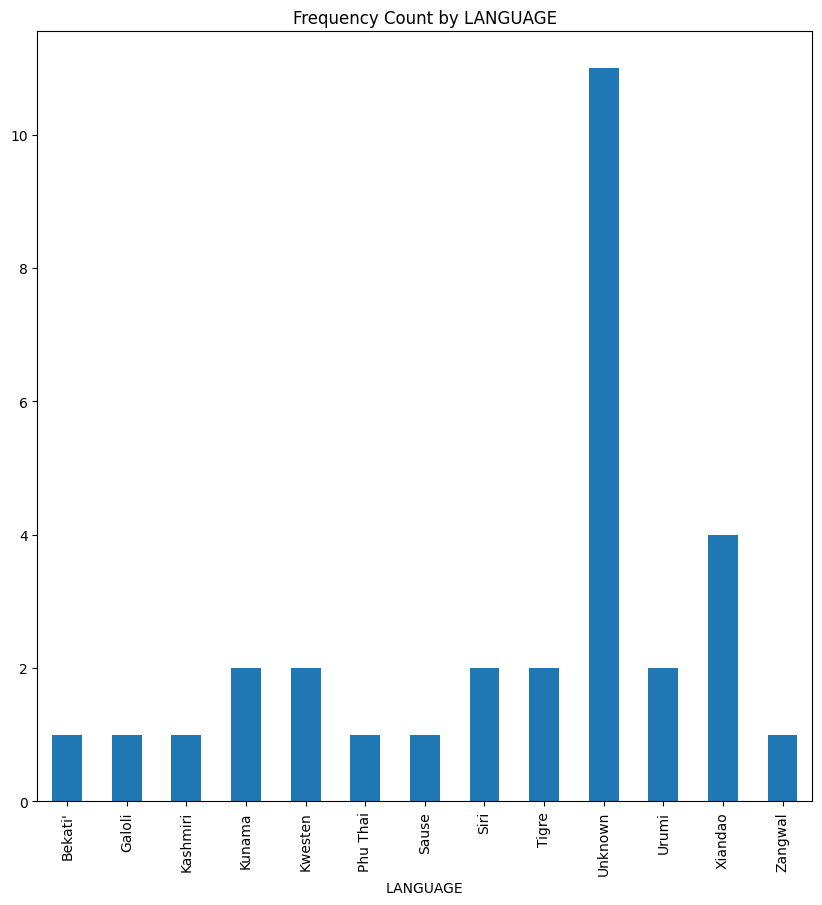

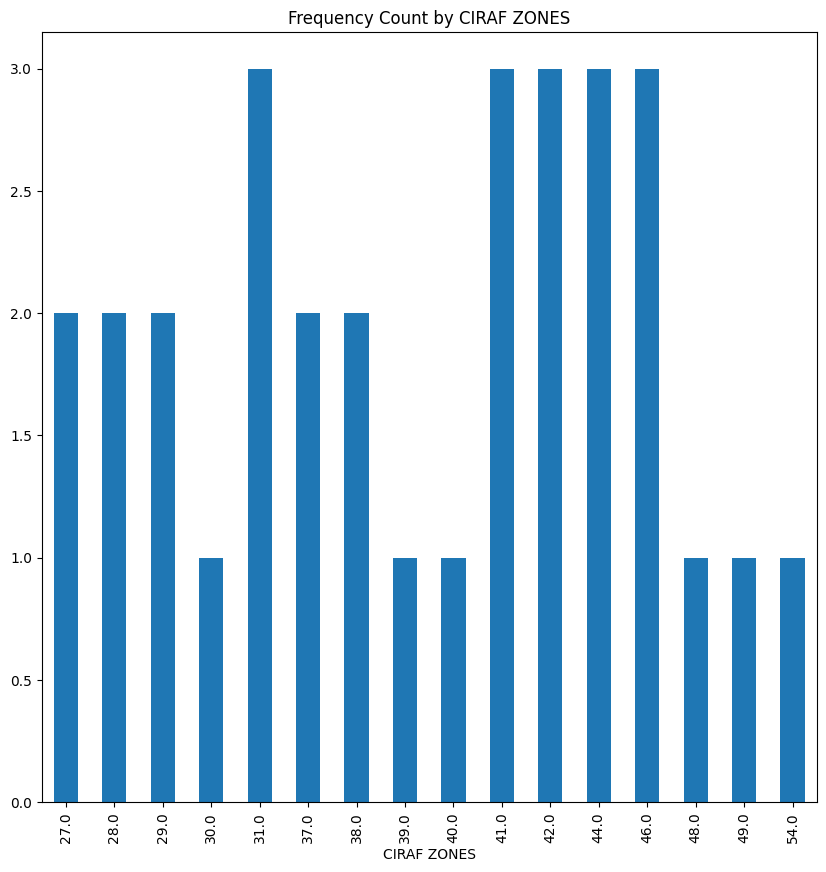

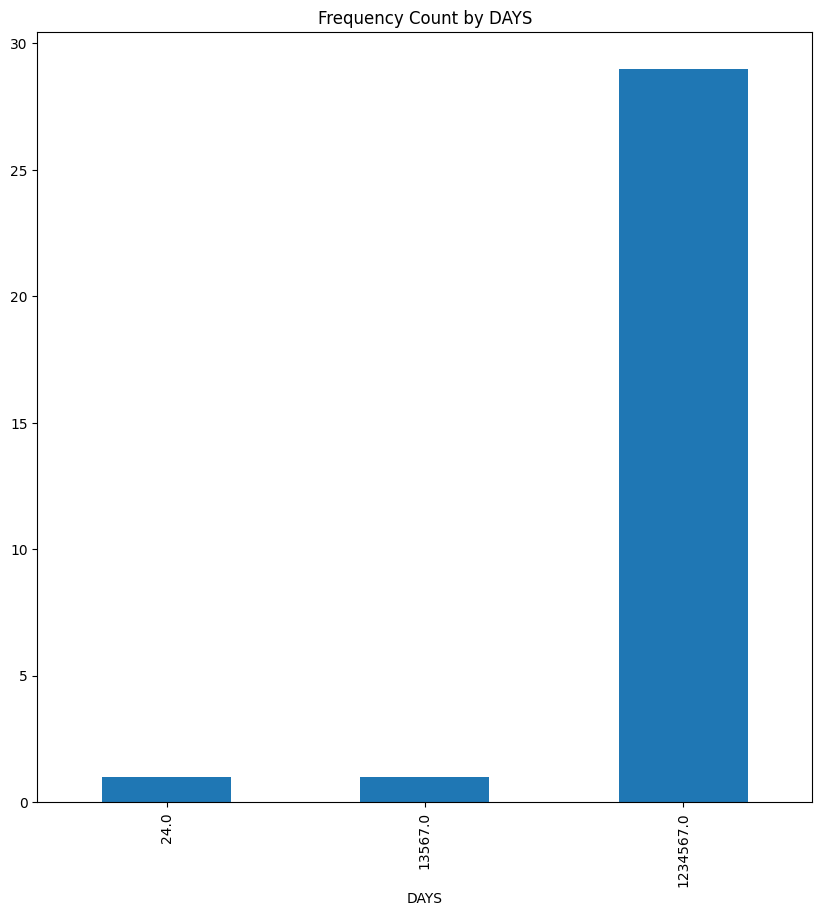

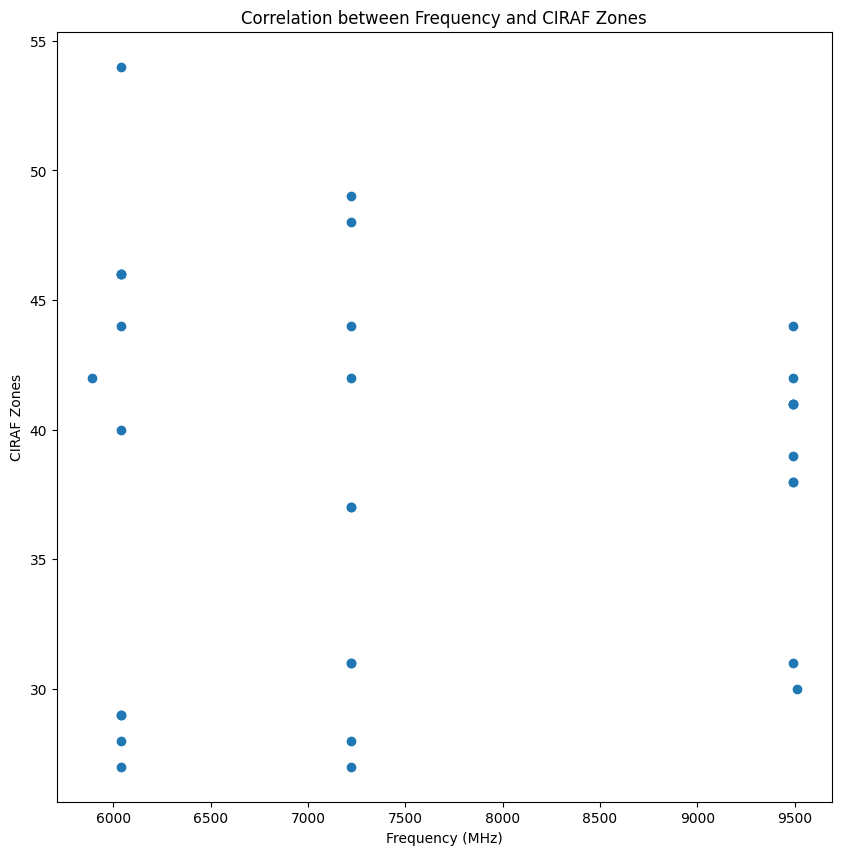

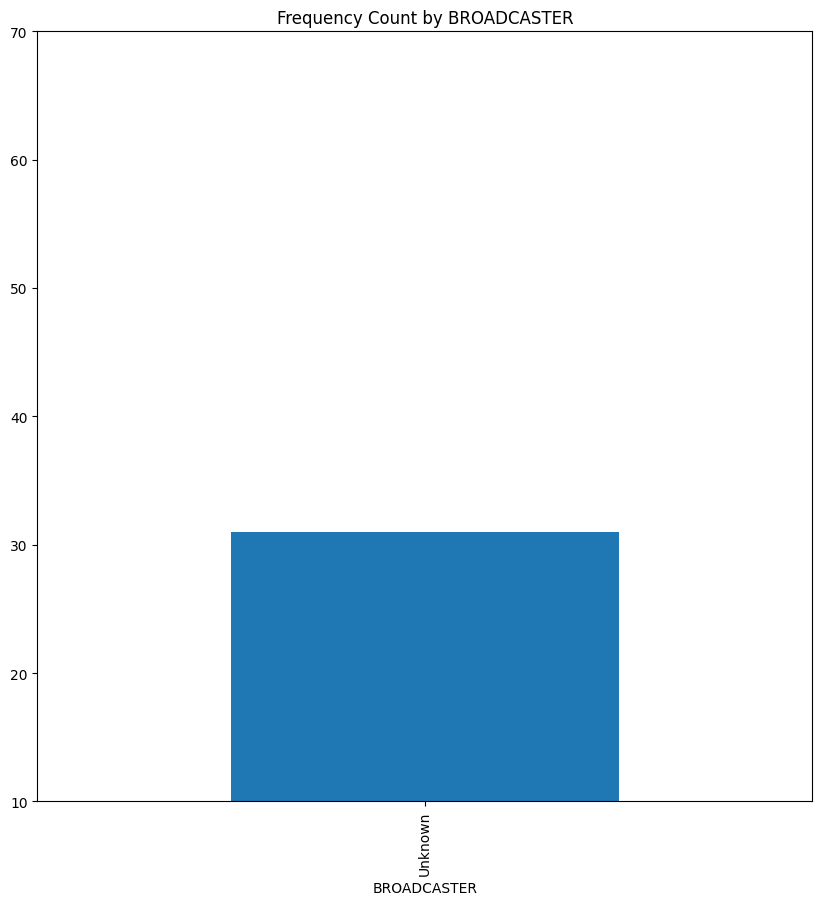

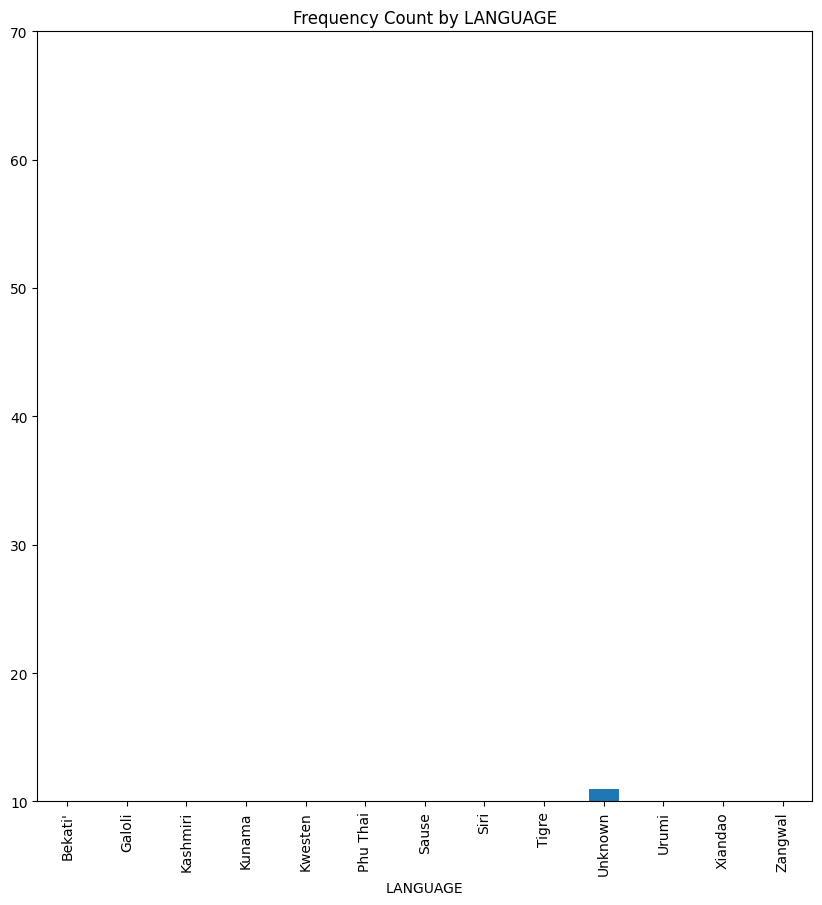

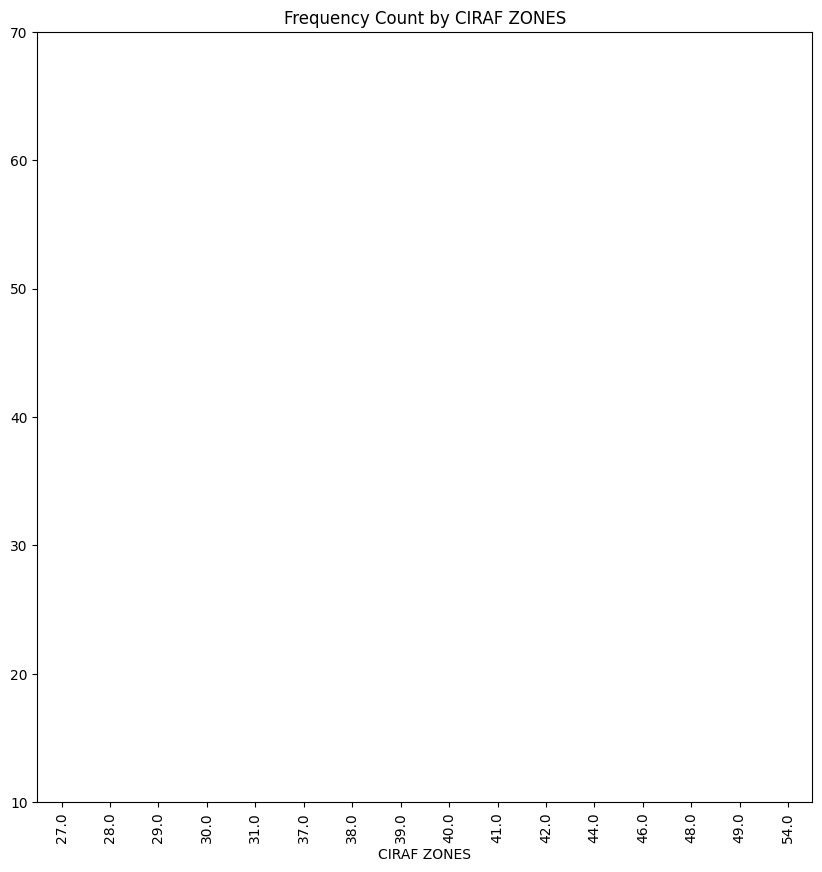

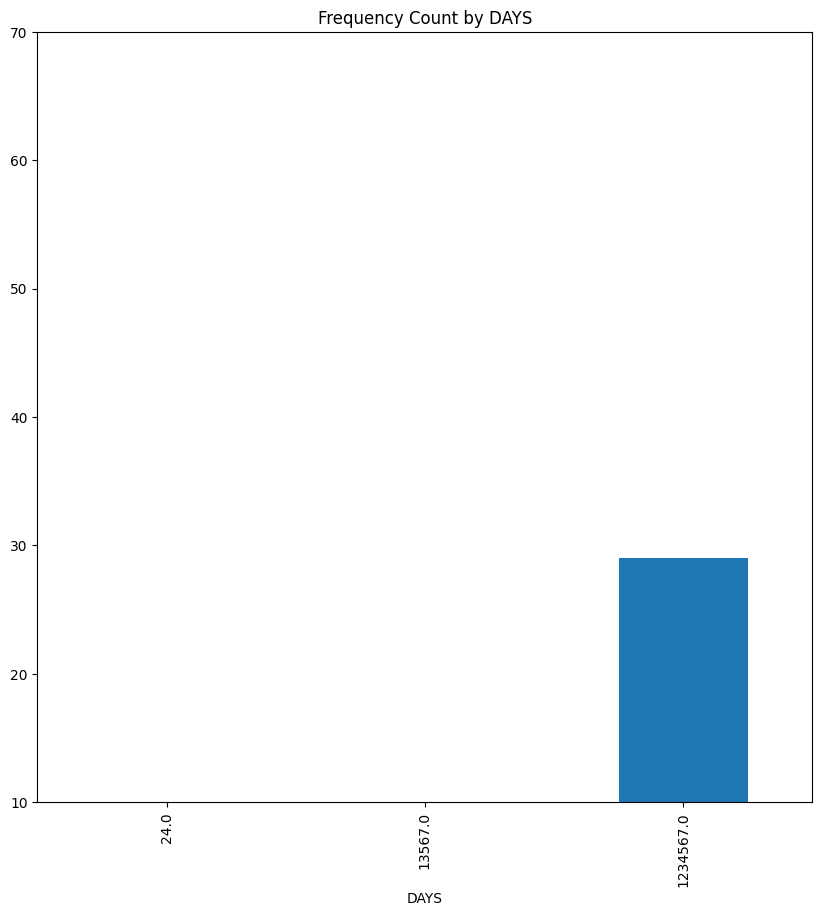

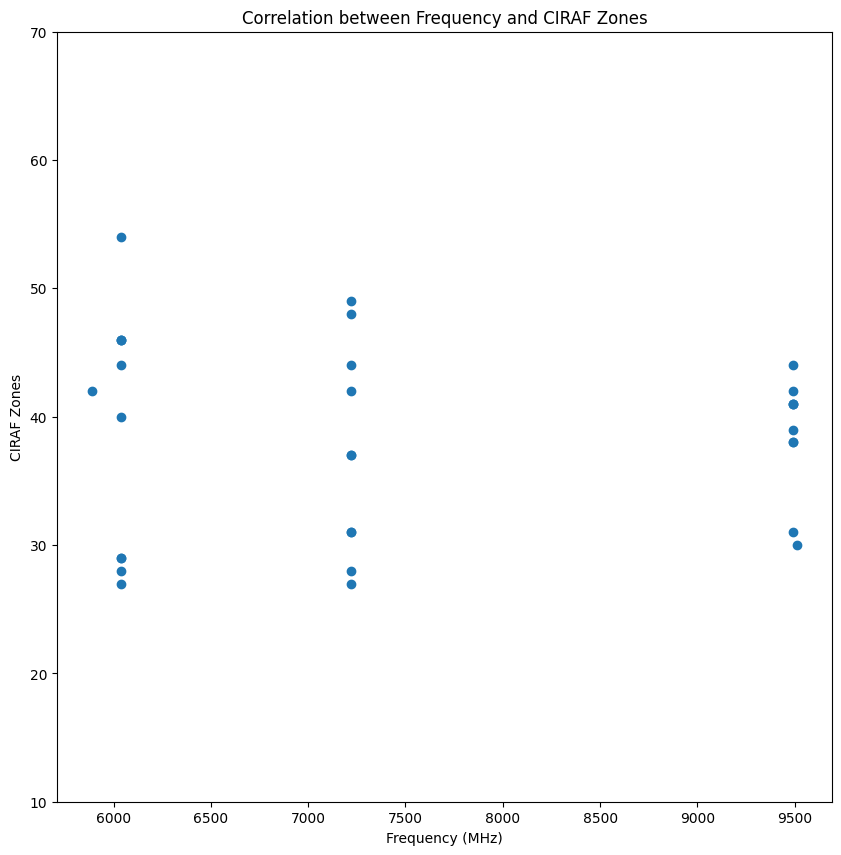

In [11]:
import tkinter as tk
from tkinter import filedialog, messagebox
import csv
import json
import os
import pandas as pd
from io import StringIO
from datetime import datetime
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np





# Global file path variables
Current_files = []
combined_data = None
# Global file path variables



#data Cleaning-----------------------------------------------------------------------------------------------------------------------------------------------------
import re

def clean_data():
    global combined_data

    if combined_data is None or combined_data.empty:
        messagebox.showwarning("No Data", "No data has been uploaded or the combined data is empty.")
        return

    # Print the shape and column names of combined_data before cleaning
    print("Shape before cleaning:", combined_data.shape)
    print("Columns before cleaning:", combined_data.columns)

    # Create a copy of combined_data to avoid SettingWithCopyWarning
    combined_data_copy = combined_data.copy()

    # Ensure 'FREQ' column is treated as a string
    combined_data_copy['FREQ'] = combined_data_copy['FREQ'].astype(str)

    # Filter rows based on specific numeric 'FREQ' values
    selected_freqs = ['5890', '6040', '7220', '9490', '9510']
    filtered_data = combined_data_copy[combined_data_copy['FREQ'].str.extract('(\d+)')[0].isin(selected_freqs)]

    # Replace missing values of numerical columns with the mean of that column
    for col in filtered_data.columns:
        if filtered_data[col].dtype in ['float64', 'int64']:
            filtered_data[col].fillna(filtered_data[col].mean(), inplace=True)

    # Replace missing values in string columns with "Unknown"
    for col in filtered_data.columns:
        if filtered_data[col].dtype == 'object':
            filtered_data[col].fillna("Unknown", inplace=True)

    # Drop duplicates in the copied DataFrame
    filtered_data.drop_duplicates(inplace=True)

    # Check if 'BROADCASTERCODE' column exists
    if 'BROADCASTERCODE' not in filtered_data.columns:
        messagebox.showerror("Error", "The 'BROADCASTERCODE' column is not present in the data.")
        return

    # Filter out specific 'BROADCASTERCODE' values
    broadcasters_to_exclude = ['ADM', 'DWL', 'KBS']
    filtered_data = filtered_data[~filtered_data['BROADCASTERCODE'].isin(broadcasters_to_exclude)]

    # Ensure 'SITE' column is copied to 'LOCATION' column
    if 'SITE' in filtered_data.columns:
        filtered_data['LOCATION'] = filtered_data['SITE']

    # Check and change column names
    if 'SITE' in filtered_data.columns:
        filtered_data.rename(columns={'SITE': 'Transmitter'}, inplace=True)
    
    if 'ADMINNAME' in filtered_data.columns:
        filtered_data.rename(columns={'ADMINNAME': 'ADMIN'}, inplace=True)

         # Rename 'ANT' and 'SITE' columns if they exist
    if 'ANT' in filtered_data.columns:
        filtered_data.rename(columns={'ANT': 'Antenna Type'}, inplace=True)


    # Update the cleaned_data in the global DataFrame
    combined_data = filtered_data

    # Print the shape of combined_data after cleaning
    print("Shape after cleaning:", combined_data.shape)

    if 'CIRAF ZONES' in combined_data.columns:
        try:
            # Extract the first number from each entry in 'CIRAF ZONES' and update the column
            combined_data['CIRAF ZONES'] = combined_data['CIRAF ZONES'].apply(lambda x: float(re.findall(r'\d+', x)[0]) if re.findall(r'\d+', x) else None)

            # Calculate mean, mode, and median
            ciraf_zones_mean = combined_data['CIRAF ZONES'].mean()
            ciraf_zones_mode = combined_data['CIRAF ZONES'].mode()[0]
            ciraf_zones_median = combined_data['CIRAF ZONES'].median()

            # Update the statistics in the GUI
            statistics_label.config(text=f"CIRAF ZONES - Mean: {ciraf_zones_mean}, Mode: {ciraf_zones_mode}, Median: {ciraf_zones_median}")
        except Exception as e:
            print(f"Error calculating statistics for 'CIRAF ZONES': {e}")
            statistics_label.config(text="Error in calculating statistics for 'CIRAF ZONES'")


                # Ensure 'POWR' and 'START' columns are numeric
    combined_data['POWR'] = pd.to_numeric(combined_data['POWR'], errors='coerce')
    combined_data['START'] = pd.to_numeric(combined_data['START'], errors='coerce')

    # Filter for 'POWR' more than 90
    combined_data = combined_data[combined_data['POWR'] > 90]

    # Filter for 'START' from 1100 onwards
    combined_data = combined_data[combined_data['START'] >= 1100]

    # Update the content of the data_preview text widget with the cleaned data
    cleaned_data_str = combined_data.to_csv(index=False)
    data_preview.config(state="normal")
    data_preview.delete(1.0, tk.END)  # Clear existing content
    data_preview.insert(tk.END, cleaned_data_str)
    data_preview.config(state="disabled")






#data Cleaning-----------------------------------------------------------------------------------------------------------------------------------------------------

#Save Data-----------------------------------------------------------------------------------------------------------------------------------------------------
def save_data():
    global combined_data

    if combined_data is None or combined_data.empty:
        messagebox.showwarning("No Data", "No data has been uploaded or the combined data is empty.")
        return

    #Ask user for the save file path with the  default extension and file types
    file_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV Files", "*.csv"), ("JSON Files", "*.json")])

    if file_path:
        try:
            file_extension = os.path.splitext(file_path)[1]
            if file_extension == ".json":
                json_data = combined_data.to_json(orient="records")
                with open(file_path, "w", newline='') as file:
                    file.write(json_data)
            elif file_extension == ".csv":
                combined_data.to_csv(file_path, index=False)

            messagebox.showinfo("File Saved", "File saved successfully.")
        except Exception as e:
            messagebox.showerror("Error", f"Error occurred while saving the file: {e}")


#Save Data-----------------------------------------------------------------------------------------------------------------------------------------------------

#CSV to JSON-----------------------------------------------------------------------------------------------------------------------------------------------------
def csv_to_json():
    global Current_files

    if not Current_files:
        messagebox.showwarning("No File", "No file has been uploaded.")
        return

    #This will assuume that there is a list to iterate through due to multiple files
    for current_file in Current_files:
        if current_file.lower().endswith('.csv'):
            data = data_preview.get("1.0", tk.END).strip()
            df = pd.read_csv(StringIO(data))
            json_data = df.to_json(orient='records', indent=2)
            data_preview.config(state="normal")
            data_preview.delete(1.0, tk.END)
            data_preview.insert(tk.END, json_data)
            data_preview.config(state="disabled")

            new_file_name_base = os.path.splitext(current_file)[0]
            new_file_name = new_file_name_base + '.json'
            
            # Check if the new file name exists, and create a unique name if it does
            timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            counter = 1
            while os.path.exists(new_file_name):
                new_file_name = f"{new_file_name_base}_{timestamp}_{counter}.json"
                counter += 1

            os.rename(current_file, new_file_name)

    #update it with the new JSON file paths
    Current_files = [os.path.splitext(file)[0] + '.json' for file in Current_files]
    file_name_label.config(text=f"Current Files: {', '.join(Current_files)}")

#CSV to JSON-----------------------------------------------------------------------------------------------------------------------------------------------------


#Data upload function-------------------------------------------------------------------------------------------------------------
def data_upload():
    global Current_files
    global combined_data

    # Allow multiple file selection
    file_paths = filedialog.askopenfilenames(filetypes=[("CSV Files", "*.csv")])

    if file_paths:
        # Update Current_files with the new file paths
        Current_files.extend(file_paths)

        # Read and merge all selected files
        for file_path in file_paths:
            try:
                # Read each file
               
                data = pd.read_csv(file_path, encoding="ISO-8859-1", usecols=lambda column: column not in ['Unnamed: 2'])


                # Rename 'LOCCODE' column to 'CODE' if it exists
                if 'LOCCODE' in data.columns:
                    data.rename(columns={'LOCCODE': 'CODE'}, inplace=True)

                # Convert 'CODE' column to string and uppercase
                if 'CODE' in data.columns:
                    data['CODE'] = data['CODE'].astype(str).str.upper()

                # Merge with combined_data
                if combined_data is not None:
                    combined_data = pd.merge(combined_data, data, on='CODE', how='outer')
                else:
                    combined_data = data
            except Exception as e:
                messagebox.showerror("Error", f"Error occurred while reading the file {file_path}: {e}")
                return

        # Update GUI 
        preview_text = combined_data.head().to_csv(index=False)
        data_preview.config(state="normal")
        data_preview.delete(1.0, tk.END)  # Clear existing content
        data_preview.insert(tk.END, preview_text)
        data_preview.config(state="disabled")
        file_name_label.config(text=f"Current Files: {', '.join(Current_files)}")




#Data upload function-------------------------------------------------------------------------------------------------------------
        

#Outputfunction-----------------------------------------------------------------------------------------------------------------------------------------------------
        
def create_plot_window(title, figure):
    #Create a separate  window for a plot
    plot_window = tk.Toplevel(window)
    plot_window.title(title)
    canvas = FigureCanvasTkAgg(figure, master=plot_window)
    canvas.draw()
    canvas_widget = canvas.get_tk_widget()
    canvas_widget.pack()
    close_button = tk.Button(plot_window, text="Close", command=plot_window.destroy)
    close_button.pack()

def output(y_min=None, y_max=None):
    global combined_data

    if combined_data is None or combined_data.empty:
        print("No data has been uploaded or the combined data is empty.")
        return

    # Convert 'FREQ' to string 
    combined_data['FREQ'] = combined_data['FREQ'].astype(str).str.strip()

    # Filter for specific frequencies
    selected_freqs = ['5890.0', '6040.0', '7220.0', '9490.0', '9510.0']
    freq_data = combined_data[combined_data['FREQ'].isin(selected_freqs)]

    if freq_data.empty:
        print("No data available for the selected frequencies.")
        return

    # Create separate plots for each category
    for category in ['BROADCASTER', 'LANGUAGE', 'CIRAF ZONES', 'DAYS']:
        if category in freq_data.columns:
            fig, ax = plt.subplots(figsize=(10, 10))
            freq_data.groupby(category)['FREQ'].count().plot(kind='bar', ax=ax, title=f'Frequency Count by {category}')
            ax.set_ylim(y_min, y_max)  # Ensure this line is added to adjust y-axis limits based on y_min and y_max
            create_plot_window(f"Frequency Count by {category}", fig)
        else:
            print(f"Column {category} not found in the data.")

    # Correlation plot
    if 'CIRAF ZONES' in combined_data.columns:
        combined_data['FREQ'] = pd.to_numeric(combined_data['FREQ'], errors='coerce')
        combined_data['CIRAF ZONES'] = pd.to_numeric(combined_data['CIRAF ZONES'], errors='coerce')
        correlation_data = combined_data.dropna(subset=['FREQ', 'CIRAF ZONES'])
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.scatter(correlation_data['FREQ'], correlation_data['CIRAF ZONES'])
        ax.set_xlabel('Frequency (MHz)')
        ax.set_ylabel('CIRAF Zones')
        ax.set_title('Correlation between Frequency and CIRAF Zones')
        if y_min is not None or y_max is not None:
            ax.set_ylim(y_min, y_max)
        create_plot_window("Correlation between Frequency and CIRAF Zones", fig)
    else:
        print("Column 'CIRAF ZONES' not found in the data.")

    correlation_coefficient = combined_data['FREQ'].corr(combined_data['CIRAF ZONES'])
    print("Correlation Coefficient between FREQ and CIRAF ZONES:", correlation_coefficient)
  



    #Outputfunction-----------------------------------------------------------------------------------------------------------------------------------------------------



















    

#GUI Components
#Declare the window
window = tk.Tk()
window.title("AP Summative")
window.geometry("900x1000")  #Set window width and height
window.configure(bg='lightgrey')  #Set window background color
#Create a label to display the current file name
file_name_label = tk.Label(window, text="Current File: None", bg='lightgrey', font=("Arial", 12))
file_name_label.pack(pady=10)

#Create a frame for the button group
button_frame = tk.Frame(window, bg='lightgray')

#Create buttons and pack them within the frame
Upload_dataset = tk.Button(button_frame, text="Upload Dataset", command=data_upload)
Upload_dataset.pack(anchor="w", padx=10, pady=40)

Transform_dataset = tk.Button(button_frame, text="Transform Dataset", command=csv_to_json)
Transform_dataset.pack(anchor="w", padx=10, pady=40)

Clean_dataset = tk.Button(button_frame, text="Clean dataset", command=clean_data)
Clean_dataset.pack(anchor="w", padx=10, pady=40)

Save_current_dataset = tk.Button(button_frame, text="Save Current Dataset", command=save_data)
Save_current_dataset.pack(anchor="w", padx=10, pady=40)

Generate_output = tk.Button(button_frame, text="Generate Output" ,command=output)
Generate_output.pack(anchor="w", padx=10, pady=40)

statistics_label = tk.Label(window, text="Statistics will appear here") 
statistics_label.pack() 

# Create entry fields for y_min and y_max
y_min_label = tk.Label(window, text="Y-Min:")
y_min_label.pack(anchor="w", padx=10, pady=5)
y_min_entry = tk.Entry(window)
y_min_entry.pack(anchor="w", padx=10, pady=5)
y_max_label = tk.Label(window, text="Y-Max:")
y_max_label.pack(anchor="w", padx=10, pady=5)
y_max_entry = tk.Entry(window)
y_max_entry.pack(anchor="w", padx=10, pady=5)

#Pack the frame within the root window
button_frame.pack(side="left")
#data preview window
data_preview = tk.Text(window,width=40, height=10, bg='white', wrap=tk.WORD)
data_preview.pack(side="right", padx=10, pady=10, fill="both", expand=True)
data_preview.config(state="disabled")
data_preview_scrollbar = tk.Scrollbar(window, command=data_preview.yview)
data_preview_scrollbar.pack(side="right", fill="y")
data_preview.config(yscrollcommand=data_preview_scrollbar.set)

#Update the "Generate Output" button to include the new y_min and y_max parameters
def generate_output():
    y_min = float(y_min_entry.get()) if y_min_entry.get() else None
    y_max = float(y_max_entry.get()) if y_max_entry.get() else None
    output(y_min=y_min, y_max=y_max)

Generate_output.config(command=generate_output)

#Prevent the window from resizing based on its content
window.pack_propagate(0)

#Start the main event loop
window.mainloop()
